In [1]:
import sys
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

from transformers import pipeline
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath(".."))

from data.dataset_factory import get_dataset_generator
from preprocessing.embedding_chunks import get_ready_to_embed_chunks
from preprocessing.mean_pool_chunks import mean_pool_chunks
from preprocessing.block_splitter import deverbose_ast

/Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get a random set of functions
gen = get_dataset_generator(
    dataset_name='sourcecodeplag',
    mode='plagiarized',
    **{}
    )
sample = next(gen)
sample = next(gen)
sample = next(gen)
print(sample.code_a)

import java.util.Scanner;

public class T7 {
	public static void main(String[] args) {
		Scanner input = new Scanner(System.in);

		System.out.print("Enter a 4 by 4 matrix row by row: ");
		double[][] m = new double[4][4];

		for (int i = 0; i < 4; i++)
			for (int j = 0; j < 4; j++)
				m[i][j] = input.nextDouble();

		System.out.print("Sum of the elements in the major diagonal is " + sumMajorDiagonal(m));
	}

	public static double sumMajorDiagonal(double[][] m) {
		double sum = 0;

		for (int i = 0; i < m.length; i++)
			sum += m[i][i];

		return sum;
	}

}



In [3]:
model_name = "microsoft/graphcodebert-base"
pipe = pipeline("feature-extraction", model=model_name)

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 2061.12it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: microsoft/graphcodebert-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.decoder.bias            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training 

In [4]:
def embed_code(sample):
    """
    Embed code chunks from a sample
    """
    chunk_a = get_ready_to_embed_chunks(sample.code_a)
    chunk_b = get_ready_to_embed_chunks(sample.code_b)

    embedded_code_a = []
    embedded_code_b = []

    for chunk in chunk_a:
        code = chunk[1]
        emb = pipe(code)
        embedded_code_a.append(emb)


    for chunk in chunk_b:
        code = chunk[1]
        emb = pipe(code)
        embedded_code_b.append(emb)
    
    return embedded_code_a, embedded_code_b

In [5]:
def embed_clean_ast(sample):
    """
    Embed ast chunks from a sample
    """
    chunk_a = get_ready_to_embed_chunks(sample.code_a)
    chunk_b = get_ready_to_embed_chunks(sample.code_b)

    embedded_code_a = []
    embedded_code_b = []

    for chunk in chunk_a:
        ast = deverbose_ast(chunk[2])
        emb = pipe(ast)
        embedded_code_a.append(emb)


    for chunk in chunk_b:
        ast = deverbose_ast(chunk[2])
        emb = pipe(ast)
        embedded_code_b.append(emb)
    
    return embedded_code_a, embedded_code_b

In [6]:
def embed_ast(sample):
    """
    Embed ast chunks from a sample
    """
    chunk_a = get_ready_to_embed_chunks(sample.code_a)
    chunk_b = get_ready_to_embed_chunks(sample.code_b)

    embedded_code_a = []
    embedded_code_b = []

    for chunk in chunk_a:
        ast = json.dumps(chunk[2], indent=4)
        emb = pipe(ast)
        embedded_code_a.append(emb)


    for chunk in chunk_b:
        ast = json.dumps(chunk[2], indent=4)
        emb = pipe(ast)
        embedded_code_b.append(emb)
    
    return embedded_code_a, embedded_code_b

In [7]:
embs_code   = embed_code(sample)
embs_clean_ast    = embed_clean_ast(sample)
embs_ast          = embed_ast(sample)

emb_code_a  =  mean_pool_chunks(embs_code[0])
emb_code_b  = mean_pool_chunks(embs_code[1])

emb_ast_a   = mean_pool_chunks(embs_ast[0])
emb_ast_b   = mean_pool_chunks(embs_ast[1])

emb_clean_ast_a  = mean_pool_chunks(embs_clean_ast[1])
emb_clean_ast_b  = mean_pool_chunks(embs_clean_ast[1])

Token indices sequence length is longer than the specified maximum sequence length for this model (3136 > 512). Running this sequence through the model will result in indexing errors


In [8]:
emb_code_a  = scipy.signal.savgol_filter(emb_code_a, 100, 3, mode='nearest')
emb_ast_a   = scipy.signal.savgol_filter(emb_ast_a, 100, 3, mode='nearest')
emb_clean_ast_a   = scipy.signal.savgol_filter(emb_clean_ast_a, 100, 3, mode='nearest')

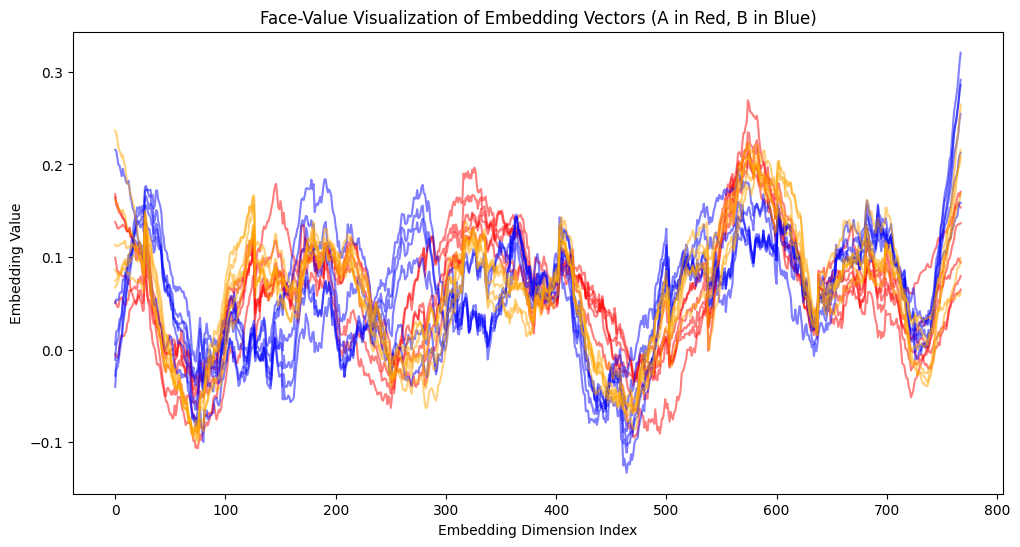

In [9]:
plt.figure(figsize=(12,6))

for vec in emb_code_a:  # emb_a.shape = (num_chunks, embedding_dim)
    plt.plot(vec, color='red', alpha=0.5)  # red for A, alpha for overlap

for vec in emb_ast_a:
    plt.plot(vec, color='blue', alpha=0.5)  # blue for B

for vec in emb_clean_ast_a:
    plt.plot(vec, color='orange', alpha=0.5)  # blue for B

plt.title("Face-Value Visualization of Embedding Vectors (A in Red, B in Blue)")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Embedding Value")
plt.show()

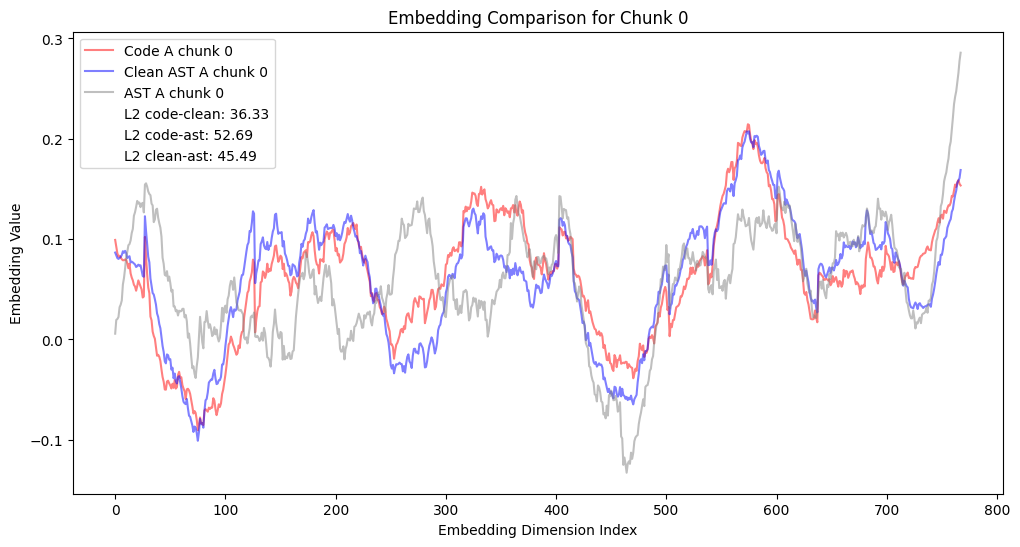

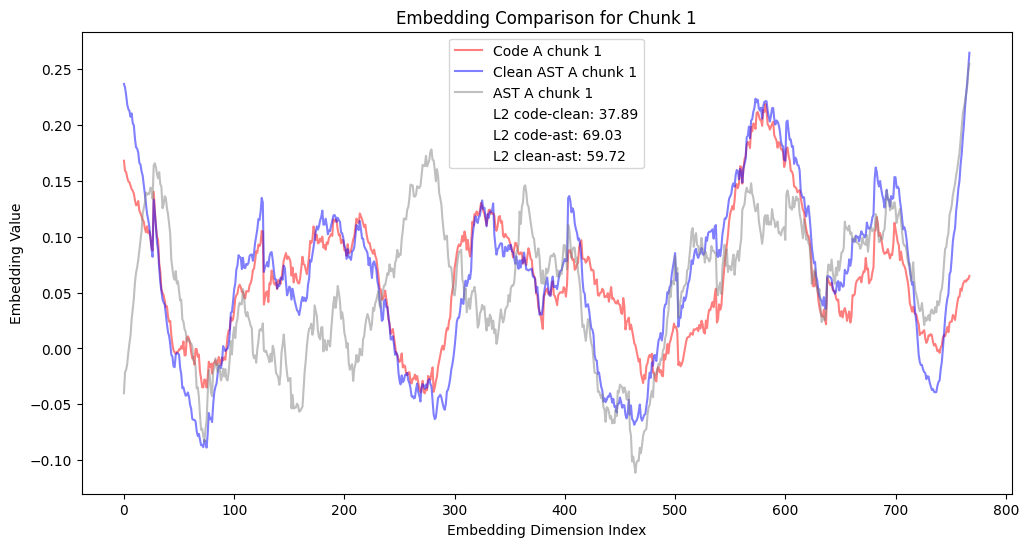

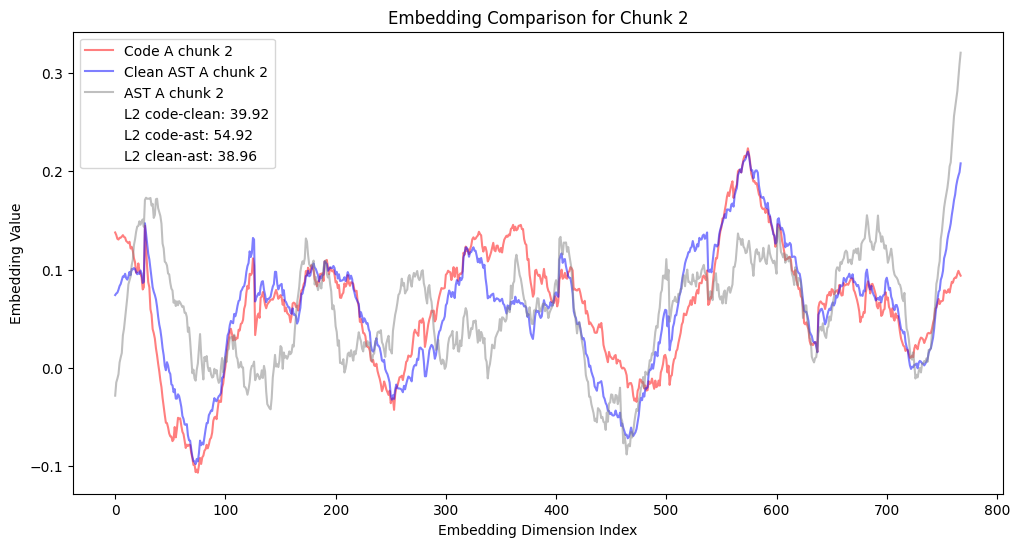

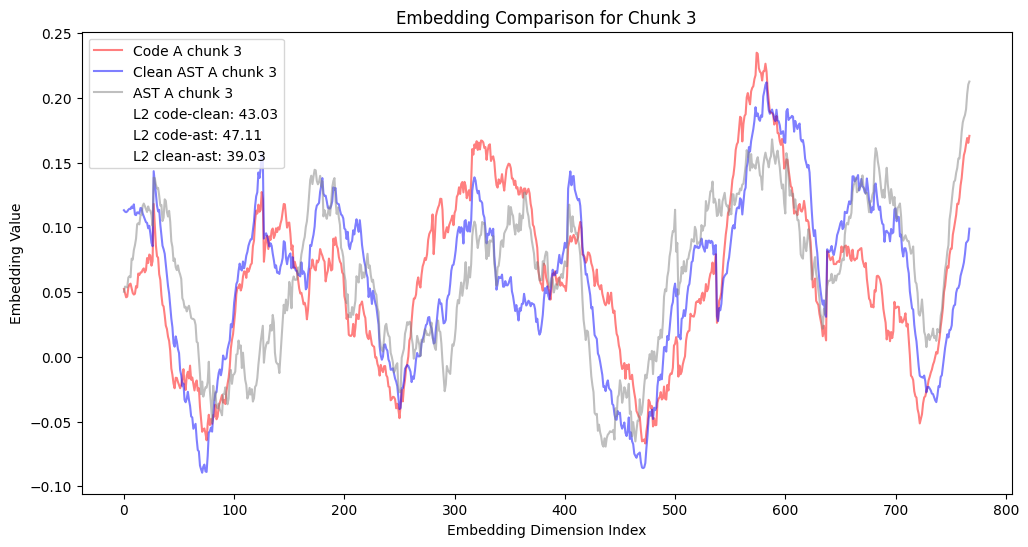

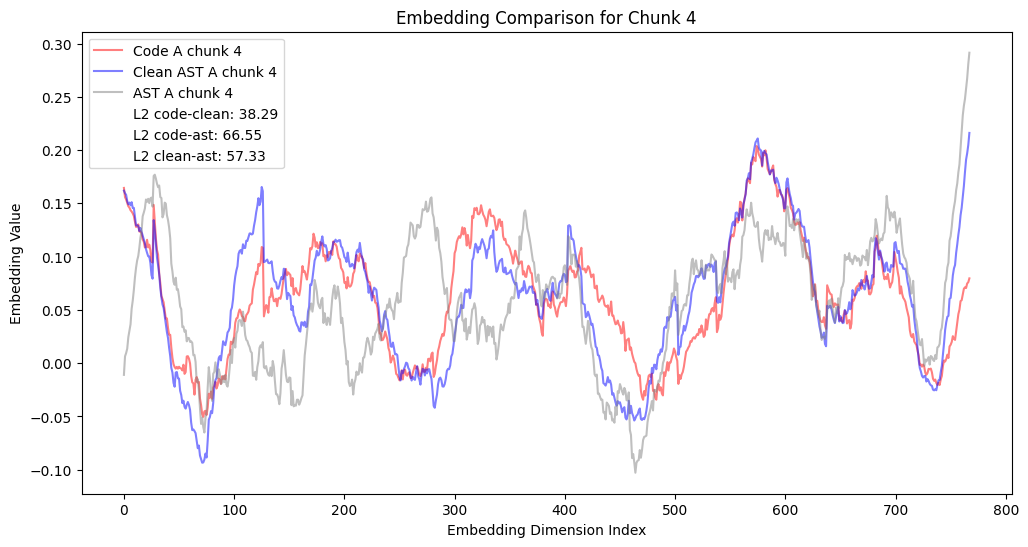

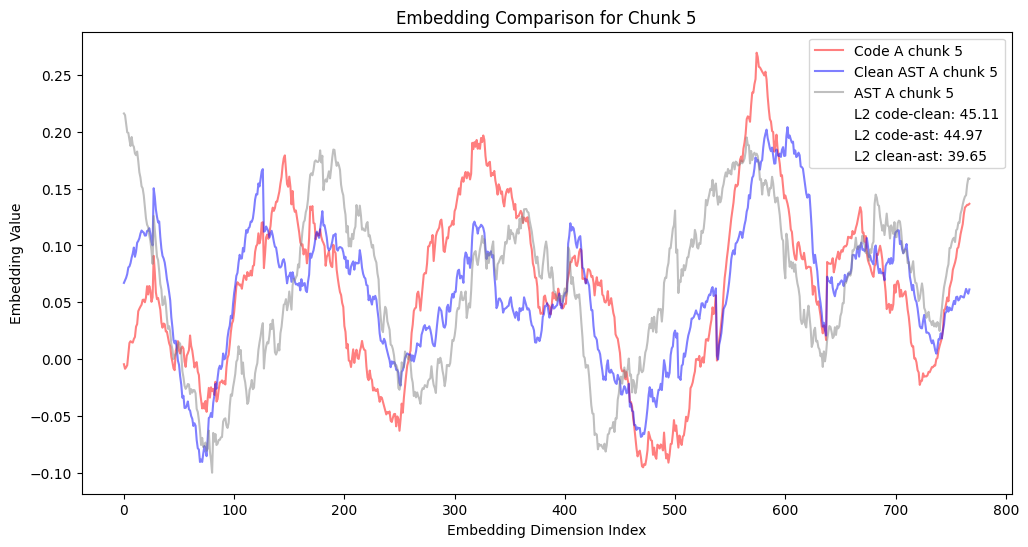

In [10]:
# Determine how many pairs to plot (shortest length of A and B)
num_pairs = min(len(emb_code_a), len(emb_ast_a), len(emb_clean_ast_a))

p = 2  # L1 distance

for i in range(num_pairs):
    plt.figure(figsize=(12,6))
    
    # Original embeddings
    code = np.array(emb_code_a[i])
    clean_ast = np.array(emb_clean_ast_a[i])
    ast = np.array(emb_ast_a[i])
    
    # Plot raw embeddings
    plt.plot(code, color='red', alpha=0.5, label=f'Code A chunk {i}')
    plt.plot(clean_ast, color='blue', alpha=0.5, label=f'Clean AST A chunk {i}')
    plt.plot(ast, color='gray', alpha=0.5, label=f'AST A chunk {i}')
    
    # Compute cumulative sums
    cum_code = np.cumsum(code)
    cum_clean_ast = np.cumsum(clean_ast)
    cum_ast = np.cumsum(ast)
    
    # Compute L1 distances between cumulative sums
    dist_code_clean = np.sum(np.abs(cum_code - cum_clean_ast)) ** (1/p)
    dist_code_ast = np.sum(np.abs(cum_code - cum_ast)) ** (1/p)
    dist_clean_ast_ast = np.sum(np.abs(cum_clean_ast - cum_ast)) ** (1/p)
    
    # Update legend labels to include cumulative distance
    plt.plot([], [], ' ', label=f'L2 code-clean: {dist_code_clean:.2f}')
    plt.plot([], [], ' ', label=f'L2 code-ast: {dist_code_ast:.2f}')
    plt.plot([], [], ' ', label=f'L2 clean-ast: {dist_clean_ast_ast:.2f}')
    
    plt.title(f"Embedding Comparison for Chunk {i}")
    plt.xlabel("Embedding Dimension Index")
    plt.ylabel("Embedding Value")
    plt.legend()
    plt.show()